# NLP Project
Quora Question Pairs


Input the dataset:
There have two dataset train data and test data.

In [56]:
import numpy as np 
import pandas as pd 


train_df = pd.read_csv("train.csv.zip")
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [57]:
test_df = pd.read_csv("test2.csv.zip")
test_df.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


Improt all the libaries that we will need in this project

In [58]:
import torch
import torch.nn as nn

# !pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# !pip install tqdm
from tqdm import tqdm


from sklearn.model_selection import train_test_split

# !pip install -c conda-forge transformers
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
transformers.logging.set_verbosity_error()



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

SEED = 1024

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cpu


# Data Analysis

## Sentence length setect
Do some analsis and remove some of the missing values, because the data is text. Then check the length of the data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


<Axes: ylabel='Count'>

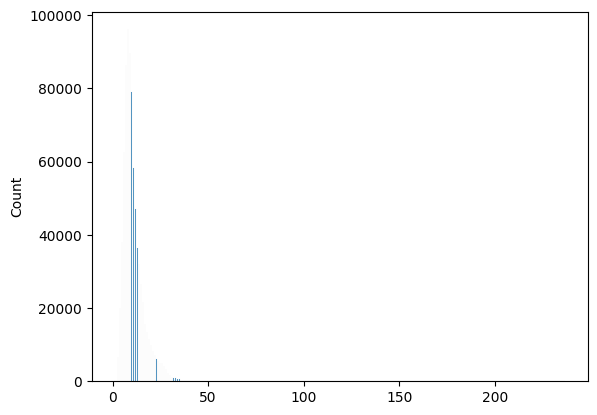

In [59]:
train_df.info()

train_df.dropna(inplace=True)
train_sentences_lens = train_df['question1'].apply(lambda x: len(x.split(' '))).tolist()
train_sentences_lens.extend(train_df['question2'].apply(lambda x: len(x.split(' '))).tolist())
sns.histplot(train_sentences_lens)


From the graph you can see that most the data are all under 50 words in every sentence.

So we can set 50 as the maximun lenth of the sentence.

In [60]:
MaximunLen = 50

## Number of the sentences
Let see how many different questions are in the data

In [61]:
qids = pd.Series(list(train_df['question1']) + list(train_df['question2']))

print ('Unique Questions number: {}\n'.format(len(np.unique(qids))))


Unique Questions number: 537359



## Analysis the duplicate and similar
Let see the percentage of duplicate and similar in the train data by analysis the duplicate in the train data.

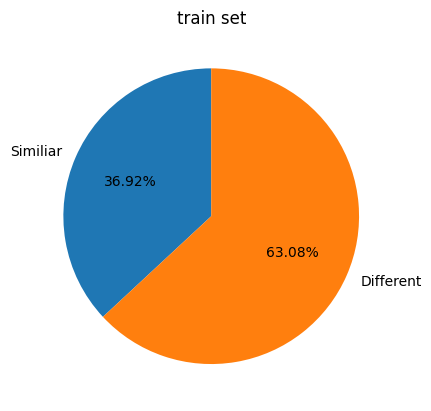

In [62]:
def pie_chart(similar_questions_num, different_questions_num, graph_title):
    labels = 'Similiar', 'Different'
    sizes = [similar_questions_num, different_questions_num]

    fig1, ax1 = plt.subplots()
    ax1.set_title(graph_title)
    ax1.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90)

    plt.show()

similar_samples_num = sum(train_df['is_duplicate'].values)
pie_chart(similar_samples_num, len(train_df['is_duplicate']) - similar_samples_num, 'train set')

## Same sentence detect
Let see if there's any paired quesions that are exacte the same.

In [63]:
duplicate_rows = train_df[train_df.duplicated(['qid1','qid2'])]
print ("Number of duplicate questions : ", len(duplicate_rows))

Number of duplicate questions :  0


## Shared words detect
Let analysis if there's shared words in both question1 and question2.

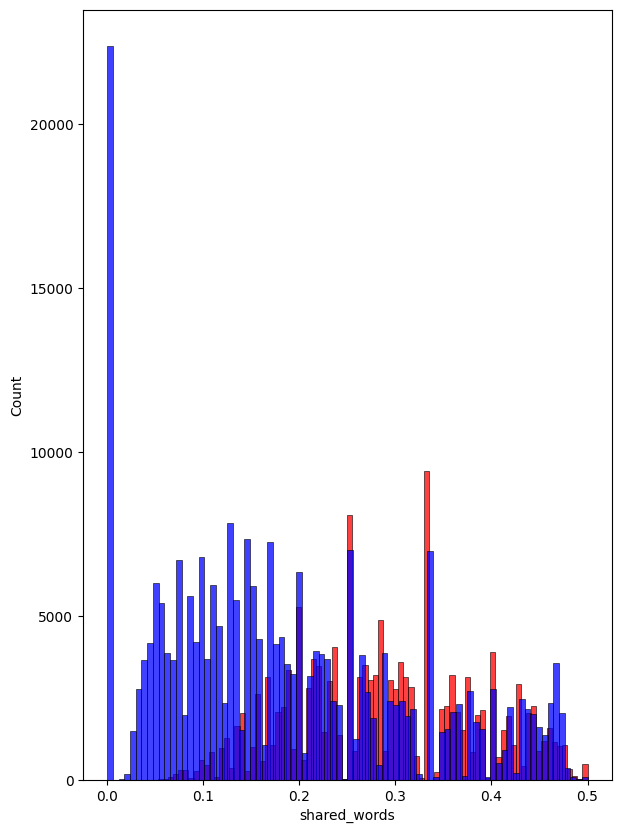

In [64]:
def shared_words(row):
    q1_word_set = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    q2_word_set = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(q1_word_set & q2_word_set) / (len(q1_word_set) + len(q2_word_set))    

train_df['shared_words'] = train_df.apply(shared_words, axis=1)
plt.figure(figsize=(15, 10))

plt.subplot(1,2,2)
sns.histplot(train_df[train_df['is_duplicate'] == 1]['shared_words'][0:] , label = "1", color = 'red')
sns.histplot(train_df[train_df['is_duplicate'] == 0]['shared_words'][0:] , label = "0" , color = 'blue' )


plt.show()

It seems that both question1 and question2 have shared words in the questions.

## load pretrain module
Let load the pretrain module and splite the data to training data and validation

In [65]:
BERT_VERSION = 'bert-base-uncased'
POOLED_OUTPUT_DIM = 768 
tokenizer = BertTokenizer.from_pretrained(BERT_VERSION)

train_df, val_df = train_test_split(train_df, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

Make a class easier to load the pretrain model. For the pretrain model we tokenize every sentence using the tokenizer(BertTokenizer.from_pretrained(bert-base-uncased)) and return a dictionary containing the input IDs, attention mask, token type IDs, and the target label.
Using "torch.utils.data.DataLoader" with the batch size and shuffle setting.

In [66]:
class BertDataSet:
    def __init__(self, questions1, questions2, targets, tokenizer):
        self.questions1 = questions1
        self.questions2 = questions2
        self.targets = targets
        self.tokenizer = tokenizer
        self.length = len(questions1)
        
    def __len__(self):
        return self.length

    def __getitem__(self, item):
        questions1 = str(self.questions1[item])
        questions2 = str(self.questions2[item])

        questions1 = " ".join(questions1.split())
        questions2 = " ".join(questions2.split())

        
        inputs = self.tokenizer.encode_plus(
            questions1,
            questions2,
            add_special_tokens=True,
            padding='max_length',
            max_length=2 * MaximunLen + 3, # max length of 2 questions and 3 special tokens
            truncation=True   
        )
        
        return {
            "ids": torch.tensor(inputs["input_ids"], dtype=torch.long),
            "mask": torch.tensor(inputs["attention_mask"], dtype=torch.long),
            "token_type_ids": torch.tensor(inputs["token_type_ids"], dtype=torch.long),
            "targets": torch.tensor(int(self.targets[item]), dtype=torch.long) if self.targets is not None else 0
        }

def get_data_loader(dataset, targets, batch_size, shuffle, tokenizer):
    dataset = BertDataSet(
        questions1=dataset["question1"].values,
        questions2=dataset["question2"].values,
        targets=targets,
        tokenizer=tokenizer
    )

    # print(dataset)
    
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size = batch_size,
        shuffle=shuffle
    )
    
    return data_loader

batchsize = 256

train_data_loader = get_data_loader(
    dataset=train_df,
    targets=train_df["is_duplicate"].values,
    batch_size=batchsize,
    shuffle=True,
    tokenizer=tokenizer
)

val_data_loader = get_data_loader(
    dataset=val_df,
    targets=val_df["is_duplicate"].values,
    batch_size=4 * batchsize,
    shuffle=True,
    tokenizer=tokenizer
)


In [67]:
# Print a batch of data from the training data loader
for batch in train_data_loader:
    print("Batch data:")
    print("Input IDs:", batch["ids"])
    print("Attention Mask:", batch["mask"])
    print("Token Type IDs:", batch["token_type_ids"])
    print("Targets:", batch["targets"])
    break  # Print only the first batch for brevity

# Print a batch of data from the validation data loader
for batch in val_data_loader:
    print("Batch data:")
    print("Input IDs:", batch["ids"])
    print("Attention Mask:", batch["mask"])
    print("Token Type IDs:", batch["token_type_ids"])
    print("Targets:", batch["targets"])
    break  # Print only the first batch for brevity


Batch data:
Input IDs: tensor([[  101,  1045,  2215,  ...,     0,     0,     0],
        [  101,  2339,  2003,  ...,     0,     0,     0],
        [  101,  2129,  2079,  ...,     0,     0,     0],
        ...,
        [  101,  2129,  2079,  ...,     0,     0,     0],
        [  101,  2129,  2097,  ...,     0,     0,     0],
        [  101, 22817, 14181,  ...,     0,     0,     0]])
Attention Mask: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
Token Type IDs: tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
Targets: tensor([1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,

In [68]:
class BertModel(nn.Module):
    def __init__(self, bert_path):
        super(BertModel, self).__init__()
        self.bert_path = bert_path
        self.bert = transformers.BertModel.from_pretrained(self.bert_path)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(POOLED_OUTPUT_DIM, 1)

    def forward(self, ids, mask, token_type_ids):
        _, pooled = self.bert(ids, attention_mask=mask,token_type_ids=token_type_ids,return_dict=False)
        
        # add dropout to prevent overfitting.
        pooled = self.dropout(pooled) 
        return self.out(pooled)

model = BertModel(BERT_VERSION).to(device)


def loss_fn(outputs, targets):
    outputs = torch.squeeze(outputs)
    return nn.BCELoss()(nn.Sigmoid()(outputs), targets)


def calculate_perplexity(data_loader, model, device):
    model.eval()
    
    with torch.no_grad():
        total_loss = 0
        for batch in data_loader:
            ids = batch["ids"].to(device, dtype=torch.long)
            mask = batch["mask"].to(device, dtype=torch.long)
            token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
            targets = batch["targets"].to(device, dtype=torch.float)

            outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            total_loss += loss_fn(outputs, targets).item()
            
    model.train()

    return np.exp(total_loss / len(data_loader))


model.safetensors: 100%|██████████| 440M/440M [00:02<00:00, 158MB/s] 


In [3]:
def train_loop(epochs, train_data_loader, val_data_loader, model, optimizer, device, scheduler=None):
    it = 1
    total_loss = 0
    curr_perplexity = None
    perplexity = None
    
    model.train()
    for epoch in range(epochs):
        print('Epoch: ', epoch + 1)
        for batch in train_data_loader:
            ids = batch["ids"].to(device, dtype=torch.long)
            mask = batch["mask"].to(device, dtype=torch.long)
            token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
            targets = batch["targets"].to(device, dtype=torch.float)

            optimizer.zero_grad()
            
            outputs = model(ids, mask=mask, token_type_ids=token_type_ids)
            
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            
            loss.backward()
            
            optimizer.step()
            
            if it % 100 == 0:
                
                # if it % 500 == 0:
                #     curr_perplexity = calculate_perplexity(val_data_loader, model, device)
                    
                #     if scheduler is not None:
                #         scheduler.step()

                #     if not perplexity or curr_perplexity < perplexity:
                #         torch.save(model.state_dict(), 'saved_model')
                #         perplexity = curr_perplexity

                print('| Iter', it, '| Avg Train Loss', total_loss / 100, '| Dev Perplexity', curr_perplexity)
                total_loss = 0

            it += 1

        # Evaluate the model on the validation set at the end of each epoch
        curr_perplexity = calculate_perplexity(val_data_loader, model, device)
                    
        if scheduler is not None:
            scheduler.step()

        if not perplexity or curr_perplexity < perplexity:
            torch.save(model.state_dict(), 'saved_model')
            perplexity = curr_perplexity

        print('| Epoch', epoch + 1, '| Avg Train Loss', total_loss / len(train_data_loader), '| Dev Perplexity', curr_perplexity)


In [70]:
def run(model, train_df, device, train_data_loader, val_data_loader):
    EPOCHS = 1
    
    lr = 3e-5
    num_training_steps = int(len(train_data_loader) * EPOCHS)
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )
    
    
    train_loop(EPOCHS, train_data_loader, val_data_loader,  model, optimizer, device, scheduler)

In [71]:
run(model, train_df, device, train_data_loader, val_data_loader)

/workspaces/NLE_project/.env/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:  1


: 